### 批量归一化（batch normalization）

在模型训练时，批量归一化利用小批量上的均值和标准差，不断调整神经网络中间输出，从而使整个神经网络在各层的中间输出的数值更稳定。

### 对全连接层做批量归一化

对全连接层来说，设全连接层的输入为u,权重参数和偏差参数分别为W和b，激活函数为$\phi$,设批量归一化的运算符为BN,那么使用批量归一化的全连接层输出为:
$\phi(BN(x))$,其中批量归一化输入x为$x=Wu+b$

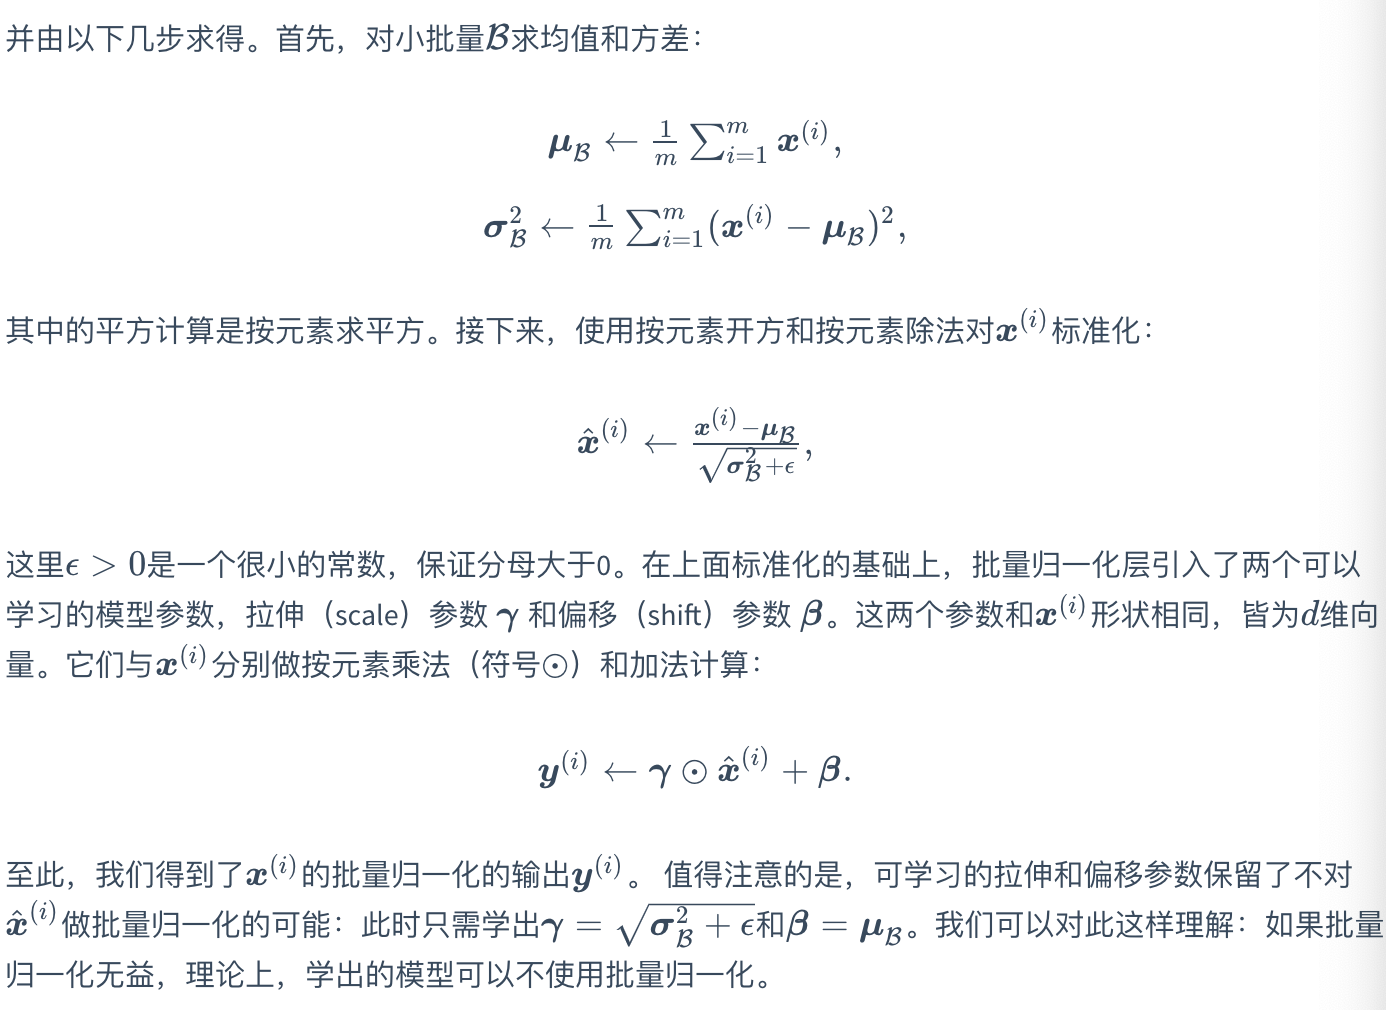

### 对卷积层做批量归一化

对卷积层来说，批量归一化发生爱卷积运算之后、应用激活函数之前。

如果卷积计算输出多个通道，我们需要对这些通道的输出分别做批量归一化，每个通道计算出独立的均值和方差，且每个通道都拥有独立的拉伸和偏移参数，并均为标量。

### 预测时的批量归一化

将训练好的模型用于预测时，我们希望模型对于任意输入都有确定的输出。因此，单个样本的输出不应取决于批量归一化所需要的随机小批量中的均值和方差。一种常用的方法是通过移动平均估算整个训练数据集的样本均值和方差，并在预测时使用它们得到确定的输出。**可见，和丢弃层一样，批量归一化层在训练模式和预测模式下的计算结果也是不一样的。**

### 从零开始实现

In [1]:
import time
import torch
from torch import nn
from torch import optim
import utils

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
#定义批量归一化函数
def batch_norm(is_training,X,gamma,beta,moving_mean,moving_var,eps,momentum):
    #判断当前模式是训练模式还是预测模式
    if not is_training:
        #如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat=(X-moving_mean)/torch.sqrt(moving_var+eps)
    else:
        assert len(X.shape) in (2,4)
        if len(X.shape)==2:
            #使用全连接层的情况，计算特征维上的均值和方差
            #计算每一列的平均值
            mean=X.mean(dim=0)
            var=((X-mean)**2).mean(dim=0)
        else:
            #使用二维卷积层的情况，计算通道维上(axis=1)的均值和方差
            #这里我们需要保持X的形状以便后面做广播运算
            mean=X.mean(dim=0,keepdim=True).mean(dim=2,keepdim=True).mean(dim=3,keepdim=True)
            var=((X-mean)**2).mean(dim=0,keepdim=True).mean(dim=2,keepdim=True).mean(dim=3,keepdim=True)
        #训练模式下用当前的均值和方差做标准化
        X_hat=(X-mean)/torch.sqrt(var+eps)
        #更新移动平均的均值和方差
        moving_mean=momentum*moving_mean+(1.0-momentum)*mean
        moving_var=momentum*moving_var+(1.0-momentum)*var
    Y=gamma*X_hat+beta  #拉伸和偏移
    return Y,moving_mean,moving_var

In [3]:
#自定义BatchNorm层，它保存参与求梯度和迭代的拉伸参数gamma和偏移参数beta
#同时维护移动平均得到的均值和方差，以便能够在模型预测时被使用。
class BatchNorm(nn.Module):
    def __init__(self,num_features,num_dims):
        #num_features:对于全连接层来说是输出个数，对卷积层来说则为输出通道数
        #num_dims:对于全连接和卷积层来说分别为2和4
        super(BatchNorm,self).__init__()
        if num_dims==2:
            shape=(1,num_features)
        else:
            shape=(1,num_features,1,1)
        #参与求梯度和迭代的拉伸和偏移参数，分别初始化成0和1
        self.gamma=nn.Parameter(torch.ones(shape))
        self.beta=nn.Parameter(torch.zeros(shape))
        #不参与梯度和迭代的变量，全在内存上初始化成0
        self.moving_mean=torch.zeros(shape)
        self.moving_var=torch.zeros(shape)
    def forward(self,X):
        #如果X不在内存上，将moving_mean和moving_var复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean=self.moving_mean.to(X.device)
            self.moving_var=self.moving_var.to(X.device)
        #Module实例的training属性默认为True,调用.eval()后设成了False
        Y,self.moving_mean,self.moving_var=batch_norm(self.training,
            X,self.gamma,self.beta,self.moving_mean,self.moving_var,
            eps=1e-5,momentum=0.9)
        return Y

In [4]:
#对LeNet加入批量归一化层
net=nn.Sequential(
    nn.Conv2d(1,6,5),
    BatchNorm(6,num_dims=4),
    nn.Sigmoid(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(6,16,5),
    BatchNorm(16,num_dims=4),
    nn.Sigmoid(),
    nn.MaxPool2d(2,2),
    utils.FlattenLayer(),
    nn.Linear(16*4*4,120),
    BatchNorm(120,num_dims=2),
    nn.Sigmoid(),
    nn.Linear(120,84),
    BatchNorm(84,num_dims=2),
    nn.Sigmoid(),
    nn.Linear(84,10)
)

In [5]:
#训练
batch_size=256
train_iter,test_iter=utils.load_data_fashion_mnist(batch_size=batch_size)

lr,num_epochs=0.001,5
optimizer=torch.optim.Adam(net.parameters(),lr=lr)
utils.train_ch5(net,train_iter,test_iter,num_epochs,device,optimizer)

train on cuda
epoch 1,train loss 1.0032,train acc 0.7914,test acc 0.8321,time 5.1 sec
epoch 2,train loss 0.4586,train acc 0.8638,test acc 0.8261,time 5.2 sec
epoch 3,train loss 0.3661,train acc 0.8782,test acc 0.7944,time 5.7 sec
epoch 4,train loss 0.3248,train acc 0.8881,test acc 0.8322,time 5.5 sec
epoch 5,train loss 0.3006,train acc 0.8950,test acc 0.8306,time 5.6 sec


### 简洁实现

Pytorch中nn模块定义的BatchNorm1d和BatchNorm2d类使用起来更加简单，二者分别用于全连接层和卷积层，都需要指定输入的num_features参数值.

In [7]:
net=nn.Sequential(
    nn.Conv2d(1,6,5),
    nn.BatchNorm2d(6),
    nn.Sigmoid(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(6,16,5),
    nn.BatchNorm2d(16),
    nn.Sigmoid(),
    nn.MaxPool2d(2,2),
    utils.FlattenLayer(),
    nn.Linear(16*4*4,120),
    nn.BatchNorm1d(120),
    nn.Sigmoid(),
    nn.Linear(120,84),
    nn.BatchNorm1d(84),
    nn.Sigmoid(),
    nn.Linear(84,10)
)

In [8]:
#训练
batch_size=256
train_iter,test_iter=utils.load_data_fashion_mnist(batch_size=batch_size)

lr,num_epochs=0.001,5
optimizer=torch.optim.Adam(net.parameters(),lr=lr)
utils.train_ch5(net,train_iter,test_iter,num_epochs,device,optimizer)

train on cuda
epoch 1,train loss 0.9913,train acc 0.7899,test acc 0.8303,time 3.7 sec
epoch 2,train loss 0.4554,train acc 0.8647,test acc 0.8602,time 4.0 sec
epoch 3,train loss 0.3636,train acc 0.8790,test acc 0.8729,time 3.7 sec
epoch 4,train loss 0.3291,train acc 0.8877,test acc 0.8449,time 3.7 sec
epoch 5,train loss 0.3075,train acc 0.8933,test acc 0.8220,time 3.6 sec
